<a href="https://colab.research.google.com/github/guebin/DL2024/blob/main/posts/05wk-2.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

# 1. 강의영상

{{<video https://youtu.be/playlist?list=PLQqh36zP38-xetJQU7iWPjyBchV8YrWO1&si=Nti_aqqC5fOyNOtP >}}

# 2. Imports

In [1]:
import torch
import matplotlib.pyplot as plt
import torchvision
import fastai.data.all 

# 3. Data: MNIST

`-` download data 

In [3]:
path = fastai.data.external.untar_data('https://s3.amazonaws.com/fast-ai-imageclas/mnist_png.tgz')
path

Path('/home/myuser/.fastai/data/mnist_png')

`-` training set 

In [10]:
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/1').ls()])
X = torch.concat([X0,X1])/255                                   # .reshape(-1,1*28*28)/255 을 하지 않음. 
y = torch.tensor([0.0]*len(X0) + [1.0]*len(X1)).reshape(-1,1)   # y의 data type은 float

In [213]:
[torchvision.io.read_image(str(fname)) for fname in (path/'training/0').ls()][0].shape , [torchvision.io.read_image(str(fname)) for fname in (path/'training/0').ls()][0].dtype

(torch.Size([1, 28, 28]), torch.uint8)

In [214]:
len([torchvision.io.read_image(str(fname)) for fname in (path/'training/0').ls()])

5923

In [215]:
[torchvision.io.read_image(str(fname)) for fname in (path/'training/0').ls()]

[tensor([[[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
             0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
          [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
             0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
          [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
             0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
          [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
             0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
          [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
             0,   0,  28,  67,  67,  67,  67,   2,   0,   0,   0,   0,   0,   0],
          [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
             0, 119, 181, 253, 253, 253, 253, 107,   0,   0,   0,   0,   0,   0],
          [  0,   0,  

In [216]:
X0.shape , X.shape ,y.dtype

(torch.Size([980, 1, 28, 28]), torch.Size([12665, 1, 28, 28]), torch.float32)

`-` test set 

In [217]:
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'testing/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'testing/1').ls()])
XX = torch.concat([X0,X1])/255                                  # .reshape(-1,1*28*28)/255 을 하지 않음
yy = torch.tensor([0.0]*len(X0) + [1.0]*len(X1)).reshape(-1,1)  # yy의 data type은 float

In [218]:
X.shape,XX.shape,y.shape,yy.shape,yy.dtype

(torch.Size([12665, 1, 28, 28]),
 torch.Size([2115, 1, 28, 28]),
 torch.Size([12665, 1]),
 torch.Size([2115, 1]),
 torch.float32)

`-` torch.Size([12665, 1, 28, 28])  가 의미하는 바.
- 데이터 수 : 12665
- channel 수 : 1 (r,g,b)
- row x column : 28,28 

# 4. CNN 예비학습

## A. 기존 ANN 모형에 대한 불만

![](https://guebin.github.io/DL2022/posts/III.%20CNN/2022-10-18-7wk-2_files/figure-html/cell-8-output-1.svg)

`-` 왜 28 $\times$ 28 이미지를 784개의 벡터로 만든 다음에 모형을 돌려야 하는가? 

`-` 기존에 개발된 모형이 회귀분석 기반으로 되어있어서 결국 회귀분석 틀에 짜 맞추어서 이미지자료를 분석하는 느낌 

`-` observation의 차원은 $784$가 아니라 $1\times (28\times 28)$이 되어야 맞다. 

## B. 새로운 아키텍처의 제시

`-` 기존 아키텍처들

- $\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,2)}{\boldsymbol u^{(1)}} \overset{relu}{\to} \underset{(n,2)}{\boldsymbol v^{(1)}} \overset{l_2}{\to} \underset{(n,1)}{\boldsymbol u^{(2)}} \overset{sig}{\to} \underset{(n,1)}{\boldsymbol v^{(2)}}=\underset{(n,1)}{\hat{\boldsymbol y}}$
- $\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,256)}{\boldsymbol u^{(1)}} \overset{relu}{\to} \underset{(n,256)}{\boldsymbol v^{(1)}} \overset{l_2}{\to} \underset{(n,1)}{\boldsymbol u^{(2)}} \overset{sig}{\to} \underset{(n,1)}{\boldsymbol v^{(2)}}=\underset{(n,1)}{\hat{\boldsymbol y}}$
- $\underset{(n,784)}{\bf X} \overset{l_1}{\to} \underset{(n,30)}{\boldsymbol u^{(1)}} \overset{relu}{\to} \underset{(n,30)}{\boldsymbol v^{(1)}} \overset{l_2}{\to} \underset{(n,1)}{\boldsymbol u^{(2)}} \overset{sig}{\to} \underset{(n,1)}{\boldsymbol v^{(2)}}=\underset{(n,1)}{\hat{\boldsymbol y}}$

`-` 아키텍처들의 공통점? 

- $l_1$: 선형변환, feature를 뽑아내는 역할 (뻥튀기 혹은 요약)
- $relu$: 뻥튀기된 feature에 비선형을 추가하여 표현력 극대화 
- $l_2$: 선형변환, 뻥튀기된 feature를 요약 하는 역할 (=데이터를 요약하는 역할) 

`-` 새로운 아키텍처 

- $conv$: feature를 뽑아내는 역할 (뻥튀기 혹은 요약) (2d ver $l_1$ 느낌) 
- $relu$: 뻥튀기된 feature에 비선형을 추가하여 표현력 극대화 
- $pooling$: 데이터를 요약하는 역할 

## C. `torch.nn.Conv2d`

`-` 우선 연산하는 방법만 살펴보자. 

**(예시1)**

In [219]:
torch.nn.Conv2d?

Init signature:
torch.nn.Conv2d(
    in_channels: int,
    out_channels: int,
    kernel_size: Union[int, Tuple[int, int]],
    stride: Union[int, Tuple[int, int]] = 1,
    padding: Union[str, int, Tuple[int, int]] = 0,
    dilation: Union[int, Tuple[int, int]] = 1,
    groups: int = 1,
    bias: bool = True,
    padding_mode: str = 'zeros',
    device=None,
    dtype=None,
) -> None
Docstring:     
Applies a 2D convolution over an input signal composed of several input
planes.

In the simplest case, the output value of the layer with input size
:math:`(N, C_{\text{in}}, H, W)` and output :math:`(N, C_{\text{out}}, H_{\text{out}}, W_{\text{out}})`
can be precisely described as:

.. math::
    \text{out}(N_i, C_{\text{out}_j}) = \text{bias}(C_{\text{out}_j}) +
    \sum_{k = 0}^{C_{\text{in}} - 1} \text{weight}(C_{\text{out}_j}, k) \star \text{input}(N_i, k)


where :math:`\star` is the valid 2D `cross-correlation`_ operator,
:math:`N` is a batch size, :math:`C` denotes a number of chann

In [220]:
torch.manual_seed(43052)
conv = torch.nn.Conv2d(1,1,(2,2)) # 입력 배치크기1, 출력 채널1, (2,2) window size
conv.weight.data, conv.bias.data

(tensor([[[[-0.1733, -0.4235],
           [ 0.1802,  0.4668]]]]),
 tensor([0.2037]))

In [221]:
_X = torch.arange(0,4).reshape(1,1,2,2).float() # 2,2 흑백이미지. 
_X

tensor([[[[0., 1.],
          [2., 3.]]]])

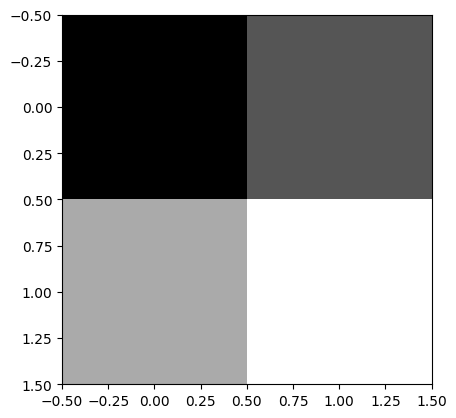

In [222]:
plt.imshow(_X.reshape(2,2),cmap="gray")

In [223]:
(-0.1733)*0 + (-0.4235)*1 +\
(0.1802)*2 + (0.4668)*3 + 0.2037

1.541

In [224]:
conv(_X).shape  # # 입력 배치크기1, 출력 채널1, (1,1) window size

torch.Size([1, 1, 1, 1])

In [225]:
conv(_X) , conv(_X).detach(), conv(_X).detach().numpy()

(tensor([[[[1.5410]]]], grad_fn=<ConvolutionBackward0>),
 tensor([[[[1.5410]]]]),
 array([[[[1.5409603]]]], dtype=float32))

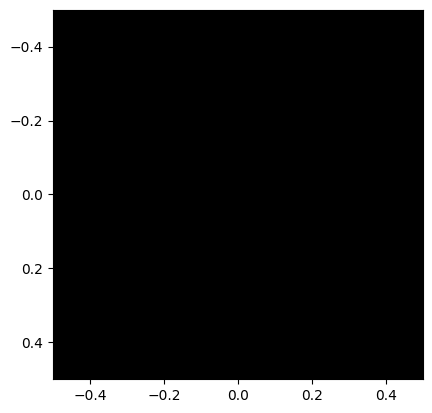

In [226]:
output_image = conv(_X).detach().numpy().reshape(1, 1)
plt.imshow(output_image, cmap="gray")


**(예시2) 평균**

In [227]:
conv = torch.nn.Conv2d(1,1,(2,2))
conv.weight.data = conv.weight.data * 0 + 1/4
conv.bias.data = conv.bias.data * 0

In [228]:
_X

tensor([[[[0., 1.],
          [2., 3.]]]])

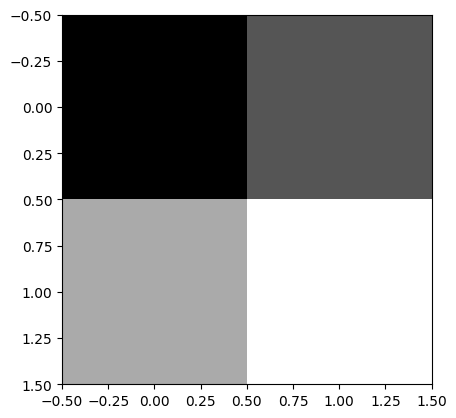

In [229]:
plt.imshow(_X.reshape(2,2),cmap="gray")

In [230]:
conv(_X)

tensor([[[[1.5000]]]], grad_fn=<ConvolutionBackward0>)

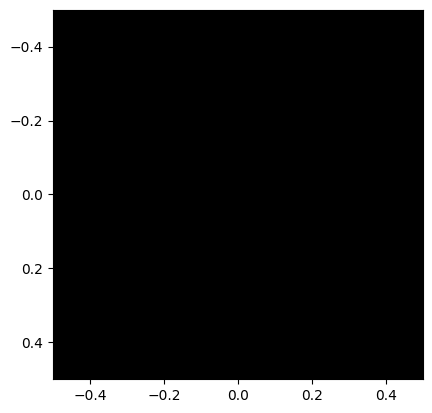

In [231]:
plt.imshow(conv(_X).detach().numpy().reshape(-1,1),cmap="gray")

**(예시3) 이동평균?**

In [232]:
_X = torch.arange(16).reshape(1,1,4,4).float()
_X,conv(_X)

(tensor([[[[ 0.,  1.,  2.,  3.],
           [ 4.,  5.,  6.,  7.],
           [ 8.,  9., 10., 11.],
           [12., 13., 14., 15.]]]]),
 tensor([[[[ 2.5000,  3.5000,  4.5000],
           [ 6.5000,  7.5000,  8.5000],
           [10.5000, 11.5000, 12.5000]]]], grad_fn=<ConvolutionBackward0>))

**(예시4) window size가 증가한다면? (2d의 이동평균느낌)**

In [233]:
_X = torch.arange(16).reshape(1,1,4,4).float()
conv = torch.nn.Conv2d(1,1,(3,3))
conv.weight.data = conv.weight.data * 0 + 1/9
conv.bias.data = conv.bias.data * 0

In [234]:
_X,conv(_X)

(tensor([[[[ 0.,  1.,  2.,  3.],
           [ 4.,  5.,  6.,  7.],
           [ 8.,  9., 10., 11.],
           [12., 13., 14., 15.]]]]),
 tensor([[[[ 5.0000,  6.0000],
           [ 9.0000, 10.0000]]]], grad_fn=<ConvolutionBackward0>))

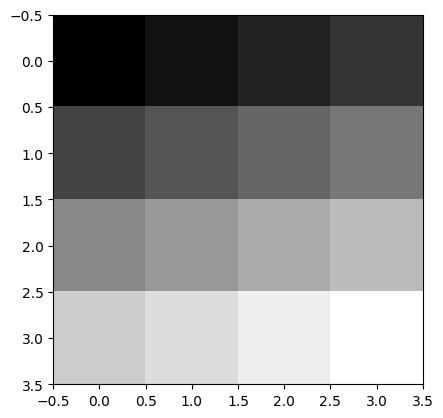

In [235]:
plt.imshow((_X).reshape(-1,4),cmap="gray")

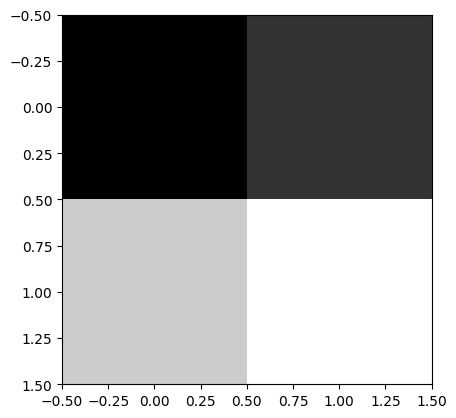

In [236]:
plt.imshow(conv(_X).detach().numpy().reshape(2,2),cmap="gray")

**(예시5)** 2개의 이미지 

In [237]:
_X = torch.arange(32).reshape(2,1,4,4).float()  # data 2개, channel 1, size : 4x4
conv = torch.nn.Conv2d(1,1,(3,3))
conv.weight.data = conv.weight.data * 0 + 1/9
conv.bias.data = conv.bias.data * 0

In [238]:
_X,conv(_X)

(tensor([[[[ 0.,  1.,  2.,  3.],
           [ 4.,  5.,  6.,  7.],
           [ 8.,  9., 10., 11.],
           [12., 13., 14., 15.]]],
 
 
         [[[16., 17., 18., 19.],
           [20., 21., 22., 23.],
           [24., 25., 26., 27.],
           [28., 29., 30., 31.]]]]),
 tensor([[[[ 5.0000,  6.0000],
           [ 9.0000, 10.0000]]],
 
 
         [[[21.0000, 22.0000],
           [25.0000, 26.0000]]]], grad_fn=<ConvolutionBackward0>))

In [241]:
conv(_X).shape

torch.Size([2, 1, 2, 2])

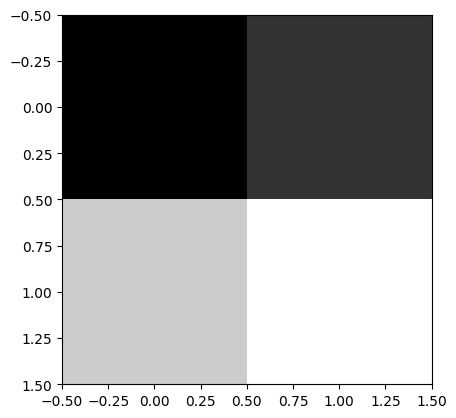

In [239]:
plt.imshow(conv(_X)[0].detach().numpy().reshape(2,2),cmap="gray")

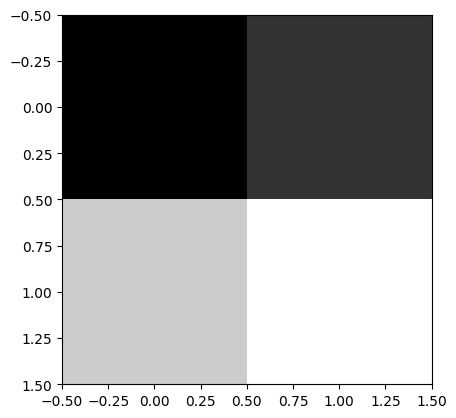

In [106]:
plt.imshow(conv(_X)[1].detach().numpy().reshape(2,2),cmap="gray")

**(예시6) 피처뻥튀기**

In [247]:
_X = torch.arange(32).reshape(2,1,4,4).float()  # data2, channel1 , 4x4
conv = torch.nn.Conv2d(1,16,(3,3))              # input channel 1, output channel 16, 3x3

In [248]:
_X.shape,conv(_X).shape

(torch.Size([2, 1, 4, 4]), torch.Size([2, 16, 2, 2]))

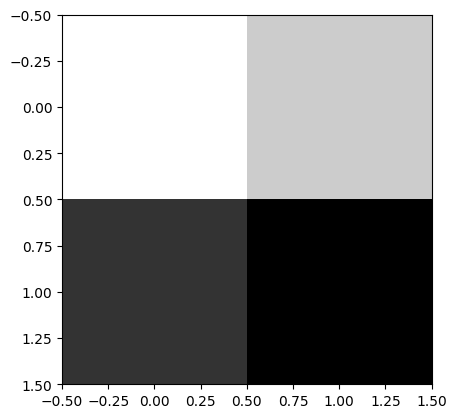

In [249]:
plt.imshow(conv(_X)[1][0].detach().numpy().reshape(2,2),cmap="gray")

In [252]:
_X[0].unsqueeze(0).shape

torch.Size([1, 1, 4, 4])

In [261]:
conv(_X[0].unsqueeze(0))[0]

IndexError: index 1 is out of bounds for dimension 0 with size 1

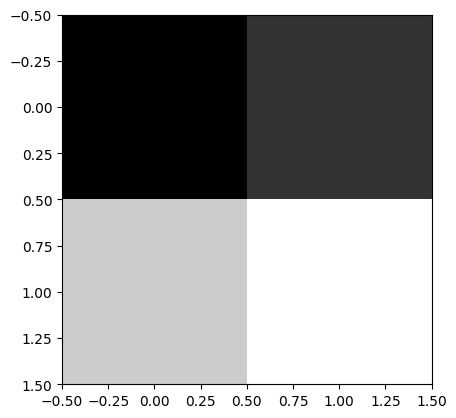

In [262]:
plt.imshow(conv(_X[1].unsqueeze(0))[0][15].detach().numpy().reshape(2,2),cmap="gray")

In [263]:
conv(_X[1].unsqueeze(0))[0][15]

tensor([[0.6395, 0.6748],
        [0.7804, 0.8156]], grad_fn=<SelectBackward0>)

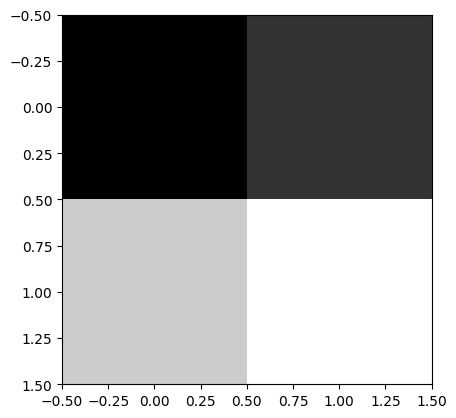

In [253]:
plt.imshow(conv(_X)[1][15].detach().numpy().reshape(2,2),cmap="gray")

In [264]:
conv(_X)[1][15]

tensor([[0.6395, 0.6748],
        [0.7804, 0.8156]], grad_fn=<SelectBackward0>)

## D. `torch.nn.ReLU`

In [265]:
a1 = torch.nn.ReLU()
_X = torch.randn(25).reshape(1,1,5,5)
_X,a1(_X)

(tensor([[[[ 0.2743, -1.2279, -1.7517, -0.0061,  0.0423],
           [-1.8412,  0.3185, -0.8445,  1.4172, -0.4230],
           [-0.2393, -0.7739, -0.6621, -0.3107, -1.1552],
           [ 0.8021, -0.0712, -2.1133,  0.1624,  0.4770],
           [-0.4605,  1.6615, -1.2009,  0.4162,  0.8022]]]]),
 tensor([[[[0.2743, 0.0000, 0.0000, 0.0000, 0.0423],
           [0.0000, 0.3185, 0.0000, 1.4172, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
           [0.8021, 0.0000, 0.0000, 0.1624, 0.4770],
           [0.0000, 1.6615, 0.0000, 0.4162, 0.8022]]]]))

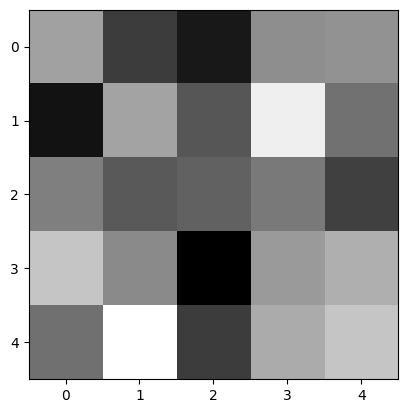

In [266]:
plt.imshow((_X).reshape(5,5),cmap="gray")

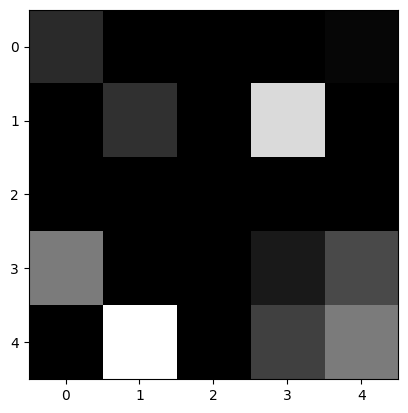

In [267]:
plt.imshow(a1(_X).detach().numpy().reshape(5,5),cmap="gray")

## E. `torch.nn.MaxPool2d`

In [268]:
m1 = torch.nn.MaxPool2d((2,2))
_X = torch.randn(25).reshape(1,1,5,5)
_X,m1(_X)

(tensor([[[[ 0.4120,  2.5184, -0.1061, -0.6232, -1.2160],
           [ 0.1979, -0.9850,  0.3811,  0.2491,  0.3282],
           [ 0.0284, -1.8565,  0.4281,  0.5050, -0.8648],
           [ 0.9710,  0.7732,  2.0936,  0.1569, -0.3604],
           [-1.3318, -1.4551, -0.0941,  1.8905,  0.4842]]]]),
 tensor([[[[2.5184, 0.3811],
           [0.9710, 2.0936]]]]))

# 5. MNIST(CPU)

In [127]:
X.shape

torch.Size([12665, 1, 28, 28])

## A. Conv2d

In [130]:
c1 = torch.nn.Conv2d(1,16,(5,5))    # in_channel : 1 , out_channel : 16 , widow : 5x5
print(X.shape)
print(c1(X).shape)

torch.Size([12665, 1, 28, 28])
torch.Size([12665, 16, 24, 24])


## B. ReLU

In [131]:
a1 = torch.nn.ReLU()
print(X.shape)
print(c1(X).shape)
print(a1(c1(X)).shape)

torch.Size([12665, 1, 28, 28])
torch.Size([12665, 16, 24, 24])
torch.Size([12665, 16, 24, 24])


## C. MaxPool2D

In [132]:
m1 =  torch.nn.MaxPool2d((2,2)) 
print(X.shape)
print(c1(X).shape)
print(a1(c1(X)).shape)
print(m1(a1(c1(X))).shape)

torch.Size([12665, 1, 28, 28])
torch.Size([12665, 16, 24, 24])
torch.Size([12665, 16, 24, 24])
torch.Size([12665, 16, 12, 12])


## D. 적당히 마무리하고 시그모이드 태우자 

`-` 펼치자. 

(방법1)

In [133]:
m1(a1(c1(X))).reshape(-1,16*12*12).shape

torch.Size([12665, 2304])

(방법2)

In [134]:
flttn = torch.nn.Flatten()

In [146]:
print(X.shape)
print(c1(X).shape)
print(a1(c1(X)).shape)
print(m1(a1(c1(X))).shape)
print(flttn(m1(a1(c1(X)))).shape)

torch.Size([12665, 1, 28, 28])
torch.Size([12665, 16, 24, 24])
torch.Size([12665, 16, 24, 24])
torch.Size([12665, 16, 12, 12])
torch.Size([12665, 2304])


`-` 2304 $\to$ 1 로 차원축소하는 선형레이어를 설계

In [136]:
l1 = torch.nn.Linear(in_features=2304,out_features=1) 
print(X.shape)
print(c1(X).shape)
print(a1(c1(X)).shape)
print(m1(a1(c1(X))).shape)
print(flttn(m1(a1(c1(X)))).shape)
print(l1(flttn(m1(a1(c1(X))))).shape)

torch.Size([12665, 1, 28, 28])
torch.Size([12665, 16, 24, 24])
torch.Size([12665, 16, 24, 24])
torch.Size([12665, 16, 12, 12])
torch.Size([12665, 2304])
torch.Size([12665, 1])


`-` 시그모이드

In [137]:
a2 = torch.nn.Sigmoid()

In [138]:
l1 = torch.nn.Linear(in_features=2304,out_features=1) 
print(X.shape)
print(c1(X).shape)
print(a1(c1(X)).shape)
print(m1(a1(c1(X))).shape)
print(flttn(m1(a1(c1(X)))).shape)
print(l1(flttn(m1(a1(c1(X))))).shape)
print(a2(l1(flttn(m1(a1(c1(X)))))).shape)

torch.Size([12665, 1, 28, 28])
torch.Size([12665, 16, 24, 24])
torch.Size([12665, 16, 24, 24])
torch.Size([12665, 16, 12, 12])
torch.Size([12665, 2304])
torch.Size([12665, 1])
torch.Size([12665, 1])


## E. 학습

`-` 네트워크 설계

In [148]:
torch.nn.MaxPool2d?

Init signature:
torch.nn.MaxPool2d(
    kernel_size: Union[int, Tuple[int, ...]],
    stride: Union[int, Tuple[int, ...], NoneType] = None,
    padding: Union[int, Tuple[int, ...]] = 0,
    dilation: Union[int, Tuple[int, ...]] = 1,
    return_indices: bool = False,
    ceil_mode: bool = False,
) -> None
Docstring:     
Applies a 2D max pooling over an input signal composed of several input planes.

In the simplest case, the output value of the layer with input size :math:`(N, C, H, W)`,
output :math:`(N, C, H_{out}, W_{out})` and :attr:`kernel_size` :math:`(kH, kW)`
can be precisely described as:

.. math::
    \begin{aligned}
        out(N_i, C_j, h, w) ={} & \max_{m=0, \ldots, kH-1} \max_{n=0, \ldots, kW-1} \\
                                & \text{input}(N_i, C_j, \text{stride[0]} \times h + m,
                                               \text{stride[1]} \times w + n)
    \end{aligned}

If :attr:`padding` is non-zero, then the input is implicitly padded with negative infinity o

In [166]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1,16,(5,5)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.Flatten(),
    torch.nn.Linear(16 * 12 * 12,1),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.Adam(net.parameters())

for epoc in range(50):
    yhat = net(X)
    loss=loss_fn(yhat,y)
    loss.backward()
    optimizr.step()
    optimizr.zero_grad()

In [139]:
net = torch.nn.Sequential(
    c1, # 2d: 컨볼루션(선형변환), 피처 뻥튀기 
    a1, # 2d: 렐루(비선형변환)
    m1, # 2d: 맥스풀링: 데이터요약
    flttn, # 2d->1d 
    l1, # 1d: 선형변환
    a2 # 1d: 시그모이드(비선형변환) 
)
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.Adam(net.parameters())
for epoc in range(50): 
    ## 1
    yhat = net(X) 
    ## 2
    loss = loss_fn(yhat,y) 
    ## 3
    loss.backward()
    ## 4
    optimizr.step()
    optimizr.zero_grad()

In [173]:
X[0].unsqueeze(0).shape

torch.Size([1, 1, 28, 28])

In [171]:
net(X[0].unsqueeze(0))

tensor([[0.0003]], grad_fn=<SigmoidBackward0>)

In [175]:
net(X).shape

torch.Size([12665, 1])

Text(0.5, 1.0, 'Traning Set')

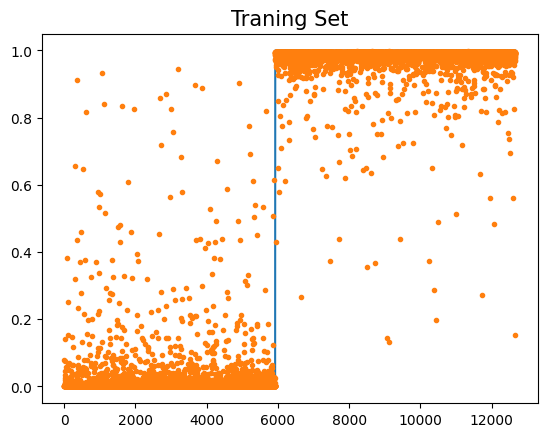

In [177]:
plt.plot(y)
plt.plot(net(X).data,'.')
plt.title('Traning Set',size=15)

Text(0.5, 1.0, 'Test Set')

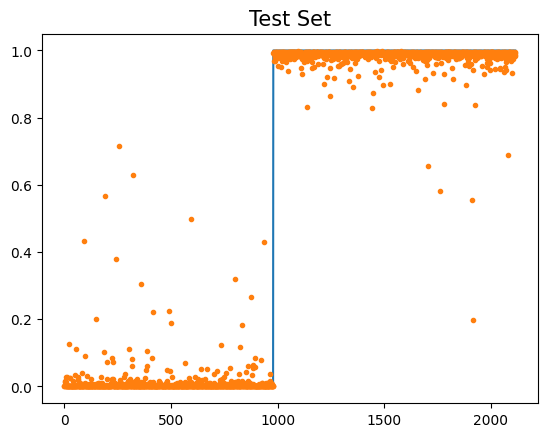

In [178]:
plt.plot(yy)
plt.plot(net(XX).data,'.')
plt.title('Test Set',size=15)

# 6. MNIST (GPU)

In [194]:
# batch size
ds = torch.utils.data.TensorDataset(X,y)
dl = torch.utils.data.DataLoader(ds,batch_size=128)
#--#
net = torch.nn.Sequential(
    torch.nn.Conv2d(1,16,(5,5)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.Flatten(),
    torch.nn.Linear(2304,1),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.Adam(net.parameters())
#--#
net.to("cuda:0")
for epoc in range(5): 
    for xi,yi in dl: 
        ## 1
        netout = net(xi.to("cuda:0")) 
        ## 2
        loss = loss_fn(netout,yi.to("cuda:0")) 
        ## 3
        loss.backward()
        ## 4
        optimizr.step()
        optimizr.zero_grad()

In [189]:
len(X) / 1024  , len(dl)

(12.3681640625, 13)

Text(0.5, 1.0, 'Training Set')

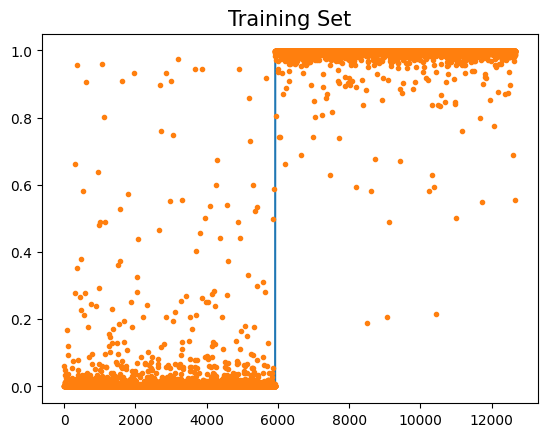

In [198]:
# plt.plot 으로 보기위해선 net 을 다시 cpu로 바꿔줘야 한다..
net.to("cpu")

plt.plot(y)
plt.plot(net(X).data,'.')
plt.title("Training Set",size=15)

Text(0.5, 1.0, 'Test Set')

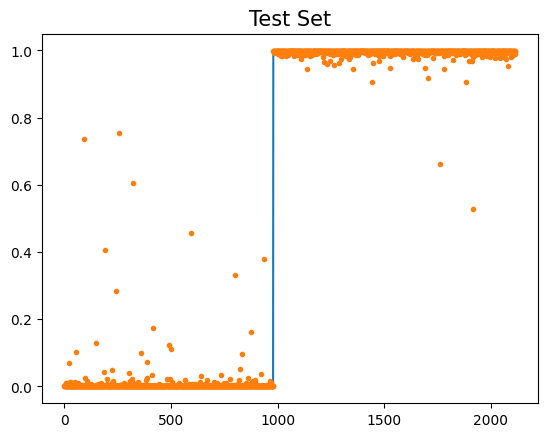

In [200]:
#net.to("cpu")
plt.plot(yy)
plt.plot(net(XX).data,'.')
plt.title("Test Set",size=15)